In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import numpy as np
import sys,os,glob
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import xarray as xr

## Add own library to path
workdir = os.getcwd()
repodir = workdir
while os.path.basename(repodir) != 'Fildier2020':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from conditionalstats import *
from plot1DInvLog import *
from importingData import *
from savingResults import *
from scalingApproximations import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

repo: /global/cscratch1/sd/bfildier/dataAnalysis/Fildier2020
Own modules available: ['thermoConstants', 'setEnv', 'thermoFunctions', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'conditionalstats', 'dataFormat', 'savingResults', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'slicingAndSubsetting', 'thermoFunctionsForMoistAdiabat', 'plot2D']


In [3]:
def getSimulationInfo(simname):
    
    chunks = simname.split('_')
    case = chunks[0]
    Nxyz = chunks[3]
    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
    simroot = '_'.join(chunks[:4])
    expname = chunks[4]
    expchunks = expname.split('-')
    SST = int([expchunk[-3:] for expchunk in expchunks if re.match("SST*",expchunk)][0])
    
    return simroot, expname, SST, Nproc

In [4]:
# simname = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r2"
simname = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1"
simroot, expname, SST, Nproc = getSimulationInfo(simname)
ndays = 10


In [5]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results',simroot,expname,
                         'stats_%ddays'%ndays)
os.makedirs(resultdir,exist_ok=True)
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [6]:
print('load data')

# 2D data
filepattern_2D = os.path.join(archivedir,simname,"OUT_2D","%s_%s.2Dcom_*.nc"%(simname,Nproc))
varids = 'Prec',
vars2D2drop = ['PBLH', 'SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC',\
            'SOLIN', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'CWP', 'IWP', 'CLD', 'USFC', 'U200',\
            'VSFC', 'V200', 'W730', 'PSFC', 'SWVP', 'U850', 'V850', 'ZC', 'TB', 'ZE']
data2D = xr.open_mfdataset(filepattern_2D,decode_cf=False,data_vars=varids,drop_variables=vars2D2drop)

# 3D data
if 'radhomo' in simname:
    NDmax = 100
else:
    NDmax = int(data2D.time.values[-1])
    
stepmax = NDmax*24*60*60//15
stepmin = stepmax - (ndays*24-1)*60*60//15
offset = 1*60*60//15 # = 1 hr lag

steprange = (stepmin-offset,stepmax-offset)
files_in_steprange = get3DFilesBetweenSteps(archivedir,simname,steprange)

vars3D2drop = ['U', 'V', 'PP', 'QRAD', 'LWU', 'LWD', 'LWUS', 'LWDS', 'QN', 'QP']
data3D = xr.open_mfdataset(files_in_steprange,decode_cf=False,drop_variables=vars3D2drop)

load data


In [7]:
# %%timeit
print("data for analysis")

# slice to analyze
# NTmax = floor(len(data2D.time)/10/24)*10*24
NTmax = NDmax*24
s_end = slice(NTmax-24*ndays,NTmax)

# data
# pr = data2D.Prec.values[s_end,:,:]
pr = data2D.Prec[s_end,:,:].values
w = data3D.W.values
tabs = data3D.TABS.values
# qv = data3D.QV.values
p_profile = np.array(np.mean(data3D.p,axis=0))
z_coord = data3D.z.values

data for analysis


In [8]:
s_end, data2D.time.values[s_end][0],files_in_steprange[0],80*24*3600/15

(slice(2160, 2400, None),
 90.041656494140625,
 '/global/cscratch1/sd/bfildier/SAM6.10.10_EDMF/archive/coriknl/RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1/OUT_3D/RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1_256_0000518400.nc',
 460800.0)

In [9]:
print(pr.shape, data3D.W.shape)

(240, 256, 256) (240, 64, 256, 256)


In [10]:
print('recompute precipitation statistics')

dist_pr_IL = Distribution(name='pr',bintype='invlogQ',fill_last_decade=True)
# Compute
dist_pr_IL.computeDistribution(sample=pr)
# Store locations of reference points in each bin
dist_pr_IL.storeSamplePoints(sample=pr,verbose=True,sizemax=500)
# Compute inverse CDF on IL bins (fraction of rain mass above percentile)
dist_pr_IL.computeInvCDF(sample=pr)
# Compute bootstrapping to estimate uncertainty on percentiles
nd_resample = 10*24 # time slices for 10 days
dist_pr_IL.bootstrapPercentiles(sample=pr,nd_resample=nd_resample)
# Compute individual percentiles for error bar on the mean
dist_pr_IL.computeIndividualPercentiles(sample=pr,ranks=[5,25,50,75,95])

recompute precipitation statistics


/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


Finding bin locations...
bin #: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..



In [11]:
print("compute conditional statistics")

# define
cdist_w_on_pr_IL = ConditionalDistribution(name='W',is3D=True,isTime=True,on=dist_pr_IL)
cdist_tabs_on_pr_IL = ConditionalDistribution(name='T',is3D=True,isTime=True,on=dist_pr_IL)
# compute conditional distributions
cdist_w_on_pr_IL.computeConditionalMeanAndVariance(data3D.W.values)
cdist_tabs_on_pr_IL.computeConditionalMeanAndVariance(data3D.TABS.values)

compute conditional statistics


In [12]:
print('compute OGS09 scaling approximation')

pr_OGS09 = np.nan*np.zeros(len(dist_pr_IL.ranks))
for iQ in range(len(dist_pr_IL.ranks)):
    w_prof = cdist_w_on_pr_IL.cond_mean[:,iQ]
    tabs_prof = cdist_tabs_on_pr_IL.cond_mean[:,iQ]
    pr_OGS09[iQ] = -scalingOGS09_zcoord(w_prof,tabs_prof,p_profile,z_coord,levdim=0)

compute OGS09 scaling approximation


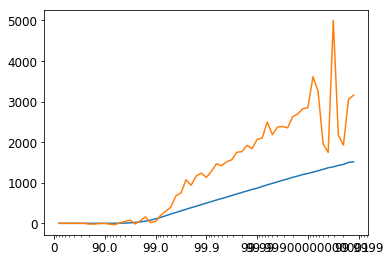

In [13]:
fig,ax = plt.subplots()
subplotRanksILog(ax,dist_pr_IL.ranks,dist_pr_IL.percentiles,transformX=False)
subplotRanksILog(ax,dist_pr_IL.ranks,pr_OGS09*86400,transformX=False)
x = np.flipud(1./(1-dist_pr_IL.ranks/100.))
transformXaxisIL(ax,x)
plt.show()

In [14]:
from scipy.optimize import curve_fit

def computePE(perc,scaling,sQ):

    x = scaling[sQ]
    y = perc[sQ]/86400
    f = lambda x,alpha: alpha*x

    eps, ecov = curve_fit(f,x,y,p0=1)
    return eps[0], ecov[0][0]

sQ9999_99999 = slice(39,49)
eps, ecov = computePE(dist_pr_IL.percentiles,pr_OGS09,sQ9999_99999)

In [15]:
eps,ecov

(0.43041903453551833, 5.0098184279384782e-05)

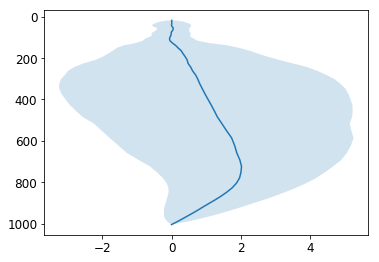

In [16]:
iQ = 39
fig,ax = plt.subplots()
ax.plot(cdist_w_on_pr_IL.cond_mean[:,iQ],p_profile)
ax.fill_betweenx(p_profile,
                 cdist_w_on_pr_IL.cond_mean[:,iQ]-cdist_w_on_pr_IL.cond_std[:,iQ],
                 cdist_w_on_pr_IL.cond_mean[:,iQ]+cdist_w_on_pr_IL.cond_std[:,iQ],
                 alpha=0.2)
ax.invert_yaxis()
plt.show()